In [16]:
import sys
sys.path.append("clustering")

from utils import get_data_dir

In [17]:
import pandas as pd
import os 

In [18]:
df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "MAG_venue_ref.parquet"))

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [19]:
df

,ReferenceVID
VID,
173952182,78376336
173952182,118093565
173952182,62159105
173952182,173952182
173952182,173952182
...,...
2764859491,170358085
2764859491,25422132
2764859491,67716761


# Node

In [20]:
import pandas as pd

# 假设你已经读入df
df = df.reset_index()  # 让VID变成普通列

# 自引数
self_cite = df[df['ReferenceVID'] == df['VID']].groupby('ReferenceVID').size().reset_index(name='self_citations')

# 被引总数
cited_count = df.groupby('ReferenceVID').size().reset_index(name='total_cited')

# 他引数（被别人引用）
outer_cite = df[df['ReferenceVID'] != df['VID']].groupby('ReferenceVID').size().reset_index(name='outer_citations')

# 引用别人或自己总数
ref_count = df.groupby('VID').size().reset_index(name='total_references')

# 合并所有属性
all_vids = pd.unique(df[['ReferenceVID', 'VID']].values.ravel())
all_vids = all_vids[~pd.isnull(all_vids)]  # 去除NaN
all_vids = all_vids.astype(int)
node_df = pd.DataFrame({'VID': all_vids})
node_df = node_df.merge(self_cite, left_on='VID', right_on='ReferenceVID', how='left').drop(columns='ReferenceVID')
node_df = node_df.merge(outer_cite, left_on='VID', right_on='ReferenceVID', how='left').drop(columns='ReferenceVID')
node_df = node_df.merge(cited_count, left_on='VID', right_on='ReferenceVID', how='left').drop(columns='ReferenceVID')
node_df = node_df.merge(ref_count, left_on='VID', right_on='VID', how='left')

# 填补缺失值为0
node_df = node_df.fillna(0).astype({
    'self_citations': int,
    'outer_citations': int,
    'total_cited': int,
    'total_references': int
})

# 计算自引比例
node_df['self_cite_pct'] = node_df['self_citations'] / node_df['total_cited'].replace(0, 1)

node_df = node_df.rename(columns={'VID': 'name'})
node_df

,name,self_citations,outer_citations,total_cited,total_references,self_cite_pct
0,78376336,1948,24974,26922,41234,0.072357
1,173952182,18301,165719,184020,145764,0.099451
2,118093565,39599,117867,157466,96592,0.251477
3,62159105,9387,71866,81253,93060,0.115528
4,24807848,65787,1191367,1257154,334283,0.052330
...,...,...,...,...,...,...
43977,2764418968,0,1,1,0,0.000000
43978,995027989,0,1,1,0,0.000000
43979,3207039989,0,0,0,10,0.000000
43980,2736799394,0,1,1,0,0.000000


In [21]:
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "clustering_results", "cluster_df.parquet"))
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,spectral_label,n2v_kmeans_label,cm_kmeans_label,gnn_kmeans_label,bert_kmeans_label
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,24,3,21,0,0
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,24,20,21,0,3
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,24,20,21,0,0
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,24,20,21,0,3
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,14,4,24,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,8,18,1,19,1
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,21,5,1,14,1
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,21,5,1,14,1
121509672,Agricultural and Biological Sciences,5,0.179111,-36.757057,-0.591017,21,0.430040,16,0.207435,10,5,1,10,1


In [22]:
node_df = pd.merge(cluster_df['kmeans_label'], node_df, how='left', left_index=True, right_on='name')

In [23]:
node_df = node_df[['name', 'kmeans_label', 'self_citations', 'outer_citations', 'total_cited', 'total_references', 'self_cite_pct']]

In [24]:
node_df

,name,kmeans_label,self_citations,outer_citations,total_cited,total_references,self_cite_pct
253,202381698,17,247889,4693463,4941352,4080795,0.050166
55,137773608,17,33004,2625459,2658463,276992,0.012415
79,125754415,17,63700,2527268,2590968,834443,0.024585
758,3880285,8,24046,2189773,2213819,255821,0.010862
706,111155417,11,129824,2096261,2226085,728068,0.058319
...,...,...,...,...,...,...,...
29869,2764485818,18,0,28,28,13,0.000000
38818,83454320,13,0,22,22,0,0.000000
38674,16507453,13,0,21,21,1,0.000000
20347,121509672,21,0,14,14,0,0.000000


In [ ]:
node_df.to_csv('clustering/data/2010s/journal_citation_net/node.csv', index=False)

# Edge

In [26]:
# 按(被引,引用)计数，得到加权边
edge_df = df.groupby(['ReferenceVID', 'VID']).size().reset_index(name='weight')
edge_df = edge_df.rename(columns={'ReferenceVID': 'source', 'VID': 'target'})
edge_df

,source,target,weight
0,0,1980519,1
1,0,3694117,1
2,0,5707928,1
3,0,5838215,1
4,0,6648857,1
...,...,...,...
28408669,3207770626,2913250823,1
28408670,3207770626,2947757084,1
28408671,3207770626,3035173479,1
28408672,3207770626,3044906433,1


In [27]:
edge_df = edge_df[edge_df['source'].isin(node_df['name']) & edge_df['target'].isin(node_df['name'])]

In [28]:
edge_df

,source,target,weight
273,61661,61661,1307
274,61661,316438,1
275,61661,920941,10
276,61661,1234972,1
277,61661,1244823,1
...,...,...,...
28408177,3207635824,21700656,1
28408178,3207635824,28964699,1
28408179,3207635824,102140811,1
28408180,3207635824,156367897,1


In [ ]:
edge_df.to_csv('clustering/data/2010s/journal_citation_net/edge.csv', index=False)

# Filtering

In [ ]:
node_df = pd.read_csv('clustering/data/2010s/journal_citation_net/node.csv')
edge_df = pd.read_csv('clustering/data/2010s/journal_citation_net/edge.csv')

In [31]:
# 筛去 source 和 target 相同的边。按 source 分组，每组取 weight 最大的前20条
edge_filtered = (
    edge_df
    .query("source != target")  # 筛选出 source 不等于 target 的边（去掉自环）
    .sort_values(['source', 'weight'], ascending=[True, False])  # 按 source 和 weight 排序
    .groupby('source', as_index=False)  # 按 source 分组
    .head(20)  # 每组取 weight 最大的前 20 条
    .reset_index(drop=True)  # 重置索引
)

In [32]:
edge_filtered

,source,target,weight
0,61661,136026792,1986
1,61661,18714766,415
2,61661,51937049,321
3,61661,191726168,318
4,61661,40121896,312
...,...,...,...
398006,3207635824,21700656,1
398007,3207635824,28964699,1
398008,3207635824,102140811,1
398009,3207635824,156367897,1


<Axes: title={'center': 'Edge Weight Distribution'}, xlabel='Weight', ylabel='Frequency'>

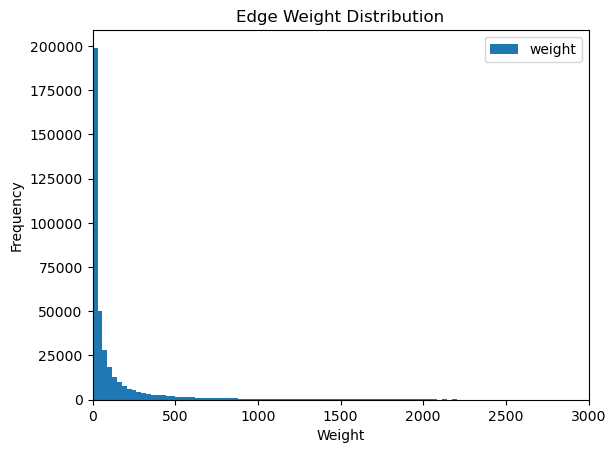

In [13]:
edge_filtered.plot(kind='hist', y='weight', bins=10000,
                   xlim=(0, 3000),
                   title='Edge Weight Distribution', xlabel='Weight', ylabel='Frequency')

In [33]:
# step 1: 找到所有实际出现在edge里的节点
used_nodes = set(edge_filtered['source']) | set(edge_filtered['target'])

# step 2: 过滤node_df
node_filtered = node_df[node_df['name'].isin(used_nodes)].reset_index(drop=True)
node_filtered

,name,kmeans_label,self_citations,outer_citations,total_cited,total_references,self_cite_pct
0,202381698,17,247889,4693463,4941352,4080795,0.050166
1,137773608,17,33004,2625459,2658463,276992,0.012415
2,125754415,17,63700,2527268,2590968,834443,0.024585
3,3880285,8,24046,2189773,2213819,255821,0.010862
4,111155417,11,129824,2096261,2226085,728068,0.058319
...,...,...,...,...,...,...,...
20032,2764485818,18,0,28,28,13,0.000000
20033,83454320,13,0,22,22,0,0.000000
20034,16507453,13,0,21,21,1,0.000000
20035,121509672,21,0,14,14,0,0.000000


In [ ]:
edge_filtered.to_csv('clustering/data/2010s/journal_citation_net/edge_filtered.csv', index=False)
node_filtered.to_csv('clustering/data/2010s/journal_citation_net/node_filtered.csv', index=False)